In [2]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
from imblearn.under_sampling import RandomUnderSampler

In [6]:
train_data = pd.read_pickle('final_train_data.pkl')

In [7]:
train_data.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C9,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V4,V6,V8,V11,V13,V18,V20,V30,V36,V37,V40,V44,V47,V48,V52,V54,V60,V70,V76,V78,V80,V81,V82,V87,V91,V99,V127,V130,V131,V139,V147,V156,V165,V166,V169,V171,V173,V174,V175,V176,V180,V183,V185,V195,V198,V203,V205,V207,V209,V210,V215,V216,V220,V221,V223,V230,V234,V235,V238,V240,V241,V250,V252,V257,V258,V260,V262,V263,V264,V265,V268,V271,V274,V277,V282,V283,V289,V291,V303,V307,V310,V312,V315,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,dollars,cents,P_parent_domain,P_domain_name,P_top_level_domain,card1_div_1000,card2_div_10,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,isFraud
0,-0.278167,4,3417,500,42,1,38,1,166,65,-0.137532,31,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.208712,-0.087363,-0.047034,-0.243806,-0.147247,-0.509782,-0.503333,-0.189393,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.563826,-1.045689,-1.416108,-1.833103,-0.195921,-0.766342,1,1,1,2,0,1,2,2,2,0.010592,-0.175584,0.254143,-0.138091,-0.107737,-1.399366,0.890708,-0.540222,0.461255,-0.664176,0.061639,-0.193368,-0.50417,-0.168338,-0.142639,-0.809739,-0.366593,0.851647,-0.51961,-0.664404,0.913909,-0.234737,-0.521953,-0.508172,-1.749900,-0.208365,-0.694394,-0.328713,-0.051788,-0.291683,-0.193128,-0.925854,-0.085075,-1.348424,0.712571,2.676527,-0.910925,-0.280643,-1.102703,-1.135389,-0.963413,-0.639484,-0.074947,-0.080622,-0.121898,1.288134,1.113841,-0.069666,-0.417482,-0.155259,-0.470968,-0.910392,-0.063384,-0.051487,-0.865095,-0.430636,-1.072947,-0.465980,-0.091838,-0.097009,-0.110508,-0.009912,-0.004928,0.202858,-0.045803,-0.093392,-0.074128,0.045677,-0.02215,-0.131410,-0.093252,-0.105377,-0.261197,-0.936267,-0.047519,-0.043218,0.198889,0.006181,-0.394673,-0.040598,-0.454041,-0.066412,-0.334849,-0.227587,-0.230241,0.540805,-0.925067,5.187305,0.029746,-0.555474,0.369252,3.588854,0.106113,0.115225,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,-0.278668,-0.447183,16,24,7,4,51,16,24,8,13,293,7,68,0
1,-0.443327,4,7922,303,42,2,2,1,173,65,-0.102667,16,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.268682,-0.097964,-0.047034,-0.243806,-0.147247,-0.598665,-0.503333,-0.210014,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.638507,-1.093292,-1.416108,-1.833103,-0.195921,-0.766342,2,2,2,0,1,1,2,2,2,0.010592,-0.175584,0.254143,-0.138091,-0.107737,-1.399366,-0.977175,-0.540222,0.461255,-0.664176,-0.925159,-0.193368,-0.50417,-0.168338,-0.142639,-0.809739,-0.366593,-0.999398,-0.51961,-0.664404,-0.959375,-0.234737,-0.521953,-0.508172,0.498307,-0.208365,-0.694394,-0.328713,-0.079398,-0.291683,-0.193128,-0.925854,-0.085075,-1.348424,0.712571,2.676527,-0.910925,-0.280643,-1.102703,-1.135389,-0.963413,-0.639484,-0.074947,-0.080622,-0.121898,1.288134,1.113841,-0.069666,-0.417482,-0.155259,-0.470968,-0.910392,-0.063384,-0.051487,-0.865095,-0.430636,-1.072947,-0.465980,-0.091838,-0.097009,-0.110508,-0.009912,-0.004928,0.202858,-0.045803,-0.093392,-0.074128,0.045677,-0.02215,-0.131410,-0.093252,-0.105377,-0.261197,-0.936267,-0.047519,-0.043218,0.198889,0.006181,-0.394673,-0.040598,-0.454041,-0.093051,-0.334849,-0.227587,-0.230241,0.540805,-0.925067,5.187305,0.029746,-0.555474,0.369252,3.588854,0.106113,0.115225,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,-0.441734,-0.475884,12,15,2,10,30,16,24,8,13,293,7,68,0
2,-0.317889,4,9383,389,42,4,58,2,178,65,0.961748,36,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.208712,-0.097964,-0.047034,-0.243806,-0.147247,-0.598665,-0.503333,-0.240946,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.638507,1.165982,-1.416108,-1.833103,-0.195921,0.864292,1,1,1,0,0,0,0,0,0,0.010592,-0.175584,0.254143,-0.1380

In [9]:
for col in train_data.columns:
    print(col)

TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
P_emaildomain
R_emaildomain
C1
C2
C4
C5
C6
C7
C9
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V3
V4
V6
V8
V11
V13
V18
V20
V30
V36
V37
V40
V44
V47
V48
V52
V54
V60
V70
V76
V78
V80
V81
V82
V87
V91
V99
V127
V130
V131
V139
V147
V156
V165
V166
V169
V171
V173
V174
V175
V176
V180
V183
V185
V195
V198
V203
V205
V207
V209
V210
V215
V216
V220
V221
V223
V230
V234
V235
V238
V240
V241
V250
V252
V257
V258
V260
V262
V263
V264
V265
V268
V271
V274
V277
V282
V283
V289
V291
V303
V307
V310
V312
V315
id_01
id_02
id_03
id_04
id_05
id_06
id_09
id_10
id_11
id_12
id_13
id_15
id_16
id_17
id_19
id_20
id_28
id_29
id_30
id_33
id_35
id_36
id_37
DeviceType
DeviceInfo
dollars
cents
P_parent_domain
P_domain_name
P_top_level_domain
card1_div_1000
card2_div_10
R_parent_domain
R_domain_name
R_top_level_domain
device_name
device_version
os_name
os_version
isFraud


In [68]:
new_train = train_data[['TransactionAmt', 
                        'ProductCD', 
                        'card4',
                        'card6', 
                        'addr1', 
                        'addr2', 
                        'dist1', 
                        'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                        'P_emaildomain',
                        'R_emaildomain',
                        'DeviceType',
                        'DeviceInfo',
                        'dollars',
                        'cents',
                        'P_parent_domain',
                        'P_domain_name',
                        'P_top_level_domain',
                        'card1_div_1000',
                        'card2_div_10',
                        'R_parent_domain',
                        'R_domain_name',
                        'R_top_level_domain',
                        'device_name',
                        'device_version',
                        'os_name',
                        'os_version',
                        'isFraud']]

In [70]:
new_train.head()

,TransactionAmt,ProductCD,card4,card6,addr1,addr2,dist1,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,R_emaildomain,DeviceType,DeviceInfo,dollars,cents,P_parent_domain,P_domain_name,P_top_level_domain,card1_div_1000,card2_div_10,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,isFraud
0,-0.278167,4,1,1,166,65,-0.137532,1,1,1,2,0,1,2,2,2,31,31,1,1735,-0.278668,-0.447183,16,24,7,4,51,16,24,8,13,293,7,68,0
1,-0.443327,4,2,1,173,65,-0.102667,2,2,2,0,1,1,2,2,2,16,31,1,1735,-0.441734,-0.475884,12,15,2,10,30,16,24,8,13,293,7,68,0
2,-0.317889,4,4,2,178,65,0.961748,1,1,1,0,0,0,0,0,0,36,31,1,1735,-0.316298,-0.475884,15,28,2,12,39,16,24,8,13,293,7,68,0
3,-0.355521,4,2,2,282,65,0.065507,2,2,2,0,1,0,2,2,2,54,31,1,1735,-0.353929,-0.475884,30,43,2,9,46,16,24,8,13,293,7,68,0
4,-0.355521,1,2,1,241,65,0.446973,2,2,2,3,2,2,2,2,2,16,31,2,954,-0.353929,-0.475884,12,15,2,12,41,16,24,8,7,249,0,58,0


In [61]:
# Feature selection
X = new_train.drop(['isFraud'], axis=1)
y = new_train['isFraud']
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [63]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(729354, 38)
(729354,)


In [64]:
rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(28010, 38)
(28010,)


In [65]:
y_train_smote.value_counts(normalize=True)

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

In [66]:
y_train_resampled.value_counts(normalize=True)

isFraud
0    0.526312
1    0.473688
Name: proportion, dtype: float64

In [67]:
K.clear_session()

In [47]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features2/base_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_auc", mode="max", patience=10)


# create reduce lr on plateau callback
reduce_lr = ReduceLROnPlateau(monitor="val_auc", mode="max", patience=5, verbose=1)
# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr]

# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_smote.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    # recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[auc])

    return model


In [48]:
## Undersampled Data
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.001)
model = create_baseline_model(adam)
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)
#  please check apakah val_auc itu beneran pake X_val y_val

Epoch 1/100
438/438 [==============================] - ETA: 0s - loss: 1.1114 - auc: 0.5115
Epoch 1: val_auc improved from -inf to 0.51011, saving model to ./model_reduced_features2/base_model_logloss_0.65_auc_0.51_checkpoint.h5
438/438 [==============================] - 14s 32ms/step - loss: 1.1114 - auc: 0.5115 - val_loss: 0.6540 - val_auc: 0.5101 - lr: 0.0010
Epoch 2/100
438/438 [==============================] - ETA: 0s - loss: 0.6846 - auc: 0.5462
Epoch 2: val_auc improved from 0.51011 to 0.64314, saving model to ./model_reduced_features2/base_model_logloss_0.70_auc_0.64_checkpoint.h5
438/438 [==============================] - 10s 22ms/step - loss: 0.6846 - auc: 0.5462 - val_loss: 0.6950 - val_auc: 0.6431 - lr: 0.0010
Epoch 3/100
434/438 [============================>.] - ETA: 0s - loss: 0.6654 - auc: 0.6064
Epoch 3: val_auc did not improve from 0.64314
438/438 [==============================] - 10s 23ms/step - loss: 0.6649 - auc: 0.6072 - val_loss: 0.6865 - val_auc: 0.6426 - lr: 

In [26]:
import seaborn as sns

<Axes: xlabel='epoch', ylabel='auc'>

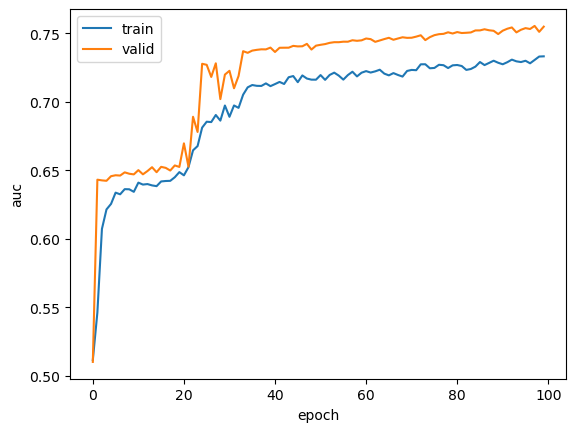

In [49]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [50]:
model = keras.models.load_model('model_reduced_features2/base_model_logloss_0.53_auc_0.76_checkpoint.h5')

In [51]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

In [52]:
y_pred = model.predict(X_test)
# using x test here

3691/3691 [==============================] - 5s 1ms/step


In [53]:
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
avg_prec_score = average_precision_score(y_test, y_pred)

In [54]:
avg_prec_score #auc-pr

0.14176233030731156

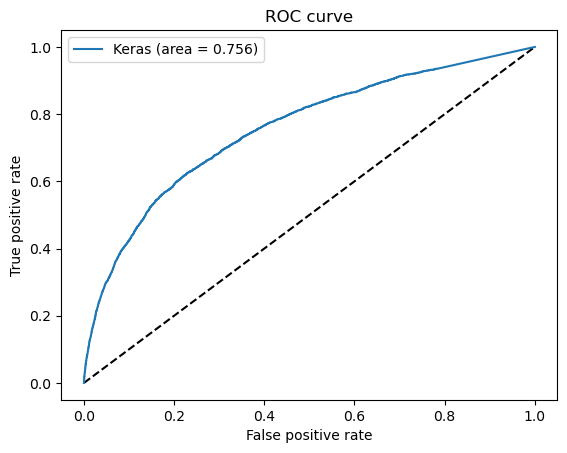

In [55]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [56]:
temp = X_test.copy()
temp['predicted'] = y_pred
temp['true'] = y_test
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

In [57]:
temp.head()

,TransactionAmt,ProductCD,card4,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,DeviceType,DeviceInfo,dollars,cents,P_parent_domain,P_domain_name,P_top_level_domain,card1_div_1000,card2_div_10,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,predicted,true
7681,-0.460052,1,4,1,130,65,-0.184703,54,31,0,1769,-0.458459,-0.475884,30,43,2,17,48,16,24,8,6,293,3,5,0.342074,0
570242,-0.075376,4,2,2,59,65,1.765699,16,31,1,1735,-0.073789,-0.475884,12,15,2,15,9,16,24,8,13,293,7,68,0.331261,0
340470,-0.256120,0,2,1,142,43,-0.186754,19,19,1,1735,-0.257762,3.961366,15,17,2,3,40,15,17,2,13,293,7,68,0.603043,0
131781,1.107920,2,4,1,255,65,-0.201110,1,1,2,1727,1.109491,-0.475884,1,1,2,3,44,1,1,2,12,293,6,11,0.348717,0
472772,-0.430993,4,4,2,127,65,-0.174448,54,31,1,1735,-0.433372,0.069444,30,43,2,17,35,16,24,8,13,293,7,68,0.300541,0


In [ ]:
# per row consider apakah dia tp, fp, fn, tn dengan bikin 4 kolom
# group by bin
# dihitung cumulative sum untuk setiap tp fp fn tn
# ini berubah seiring threshold berubah
# non-cumulative ngitung precision itu di bin itu doang (bins nya adalah populasi)
# fraud rate
# masukin y_val
# transaksi masuk, kemungkinan dia dihitung fraud berapa? -> fraud rate

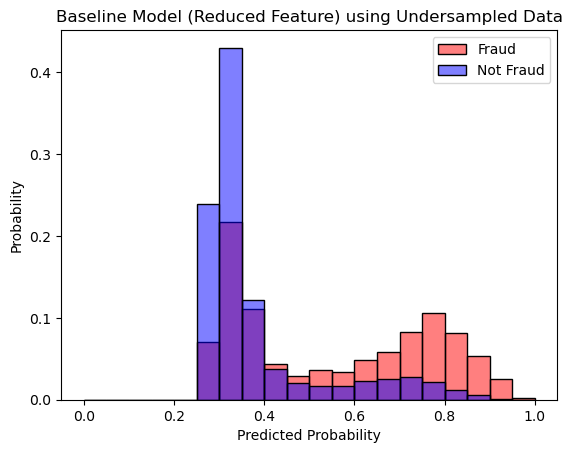

In [58]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model (Reduced Feature) using Undersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

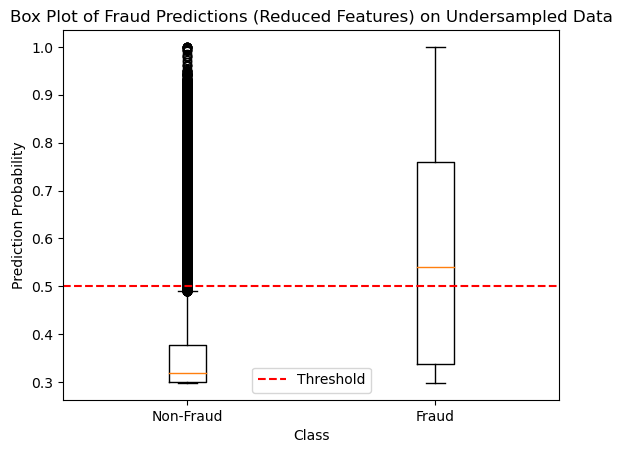

In [59]:
fraud_cases = y_pred[y_test==1]
non_fraud_cases = y_pred[y_test==0]
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions (Reduced Features) on Undersampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Based on this, we can decide that the threshold is 0.39. Let's calculate the confusion matrix

In [ ]:
y_pred_binary = (y_pred > 0.39).astype(int)
cm = confusion_matrix(y_val, y_pred_binary)

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

[Text(0, 0.5, 'Non Fraud'), Text(0, 1.5, 'Fraud')]

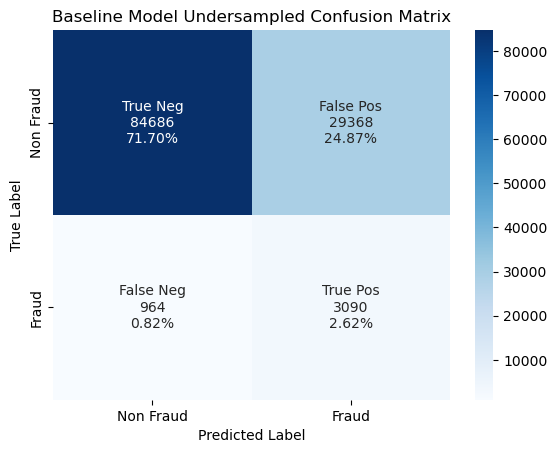

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title("Baseline Model Undersampled Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])

In [ ]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = (2 * recall * precision) / (recall + precision)
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")
print(f"AUC: {auc_keras}")

False Positive Rate: 0.2574920651621162
Recall: 0.7622101628021707
Precision: 0.09519995070552714
Accuracy: 0.7431842042876011
F1: 0.16925942156003507
AUC: 0.8371240352926064


In [ ]:
K.clear_session()